In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import itertools
import warnings
from scipy.sparse import csr_matrix

import pandas as pd
import statsmodels.api as sm 

In [53]:
# dont ignore the first line of the csv files. Keep variable as np array

def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

unwrapped_complex_names = read_names("data/complex_names.txt")
unwrapped_monomer_names = read_names("data/protein_names.txt")
unwrapped_cofactor_names = read_names("data/cofactor_names.txt")
unwrapped_element_names = read_names("data/element_ids.txt")
unwrapped_pathway_names = read_names("data/pathway_names.txt")

complex_ids = read_names("data/complex_ids.txt")
monomer_ids = read_names("data/protein_ids.txt")
cofactor_ids = read_names("data/cofactor_ids.txt")
element_ids = read_names("data/element_ids.txt")
pathway_ids = read_names("data/pathway_ids.txt")
aa_ids = read_names("data/amino_acid_ids.txt")

unwrapped_protein_names = np.concatenate([unwrapped_complex_names, unwrapped_monomer_names])
protein_ids = np.concatenate([complex_ids, monomer_ids])

# Reading the matrix CSV files
def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

C = read_matrix("data/C_matrix.csv", sparse=True)
P = read_matrix("data/P_matrix.csv", sparse=True)
E = read_matrix("data/E_matrix.csv", sparse=True)
W = read_matrix("data/W_matrix.csv", sparse=True)
W2 = read_matrix("data/W2_matrix.csv", sparse=True)
W1 = read_matrix("data/W1_matrix.csv", sparse=True)
A = read_matrix("data/A_matrix.csv")
Tree = read_matrix("data/tree_matrix.csv", sparse=True)

total_counts_min = read_matrix("data/counts.csv")
total_counts = read_matrix("data/rich_counts.csv")
total_counts_anaero = read_matrix("data/anaerobic_counts.csv")
total_counts_big = read_matrix("data/rich_counts_big.csv")
total_counts_big = total_counts_big[:, 1:-1]

monomer_masses = read_matrix("data/monomer_masses.csv").flatten()
monomer_areas = read_matrix("data/monomer_areas.csv").flatten()
complex_areas = read_matrix("data/complex_areas.csv").flatten()
protein_areas = np.concatenate([complex_areas, monomer_areas])

In [54]:
C

<5527x4434 sparse matrix of type '<class 'numpy.int64'>'
	with 6208 stored elements in Compressed Sparse Row format>

/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/cyrus/.pyenv/versions/viv-10/lib/py

<Axes: xlabel='Atoms/cell', ylabel='Count'>

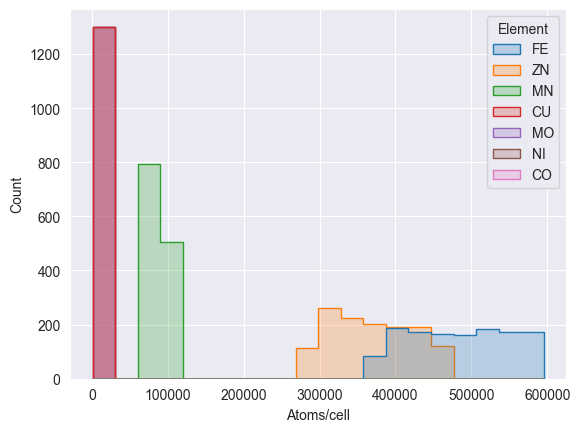

In [58]:
# find the indices of "FE", "ZN", "MN", "CU", "MO", "NI", "CO":
elements = ["FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

# compute the timeseries for the elements
element_timeseries = total_counts @ C @ P @ E[:, element_indices]

# convert to polars dataframe
element_df = pl.DataFrame(element_timeseries, schema=elements)

# melt to long form
element_df = element_df.melt(id_vars=None, value_name="Atoms/cell", variable_name="Element")
sns.histplot(element_df, x="Atoms/cell", hue="Element", element="step")

# plt.xscale("log")

In [60]:
pl.read_csv('external_data/distances_rich.csv')

Below LOD,Cell,Element,Distance
i64,i64,str,f64
0,1,""" MO""",146.248788
0,0,""" MO""",97.206029
0,1,""" SE""",152.493722
0,0,""" SE""",65.996332
0,1,""" ZN""",207.787945
0,0,""" ZN""",159.627693
0,1,""" CU""",181.919225
0,0,""" CU""",84.717286
1,1,""" NI""",125.738288
